In [9]:
# Create a Python script (e.g., plastic_bottle_detector.py) with the following functions 
# to load and preprocess the dataset:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

base_path = "/plastic-fantastic/data/dataset/"


In [2]:

def load_yolo_annotations(image_dir, label_dir):
    image_paths = []
    labels = []

    for file_name in os.listdir(label_dir):
        if file_name.endswith(".txt"):
            with open(os.path.join(label_dir, file_name), "r") as label_file:
                image_name = file_name[:-4] + ".jpg"
                image_path = os.path.join(image_dir, image_name)
                image = cv2.imread(image_path)

                if image is None:
                    print(f"Warning: Unable to read image {image_path}")
                    continue

                h, w, _ = image.shape

                for line in label_file.readlines():
                    try:
                        values = list(map(float, line.strip().split()))
                        if len(values) != 5:
                            print(f"Skipping line with unexpected format: {line.strip()}")
                            continue
                        class_id, x_center, y_center, width, height = values
                    except ValueError as e:
                        print(f"Error processing line: {line.strip()} - {e}")
                        continue

                    # Ignore other classes
                    if class_id == 0:
                        image_paths.append(image_name)
                        labels.append([x_center * w, y_center * h, width * w, height * h])

    return image_paths, labels

def load_dataset(base_path, input_shape):
    image_paths_train, labels_train = load_yolo_annotations(os.path.join(base_path, "train/images"), os.path.join(base_path, "train/labels"))
    image_paths_test, labels_test = load_yolo_annotations(os.path.join(base_path, "test/images"), os.path.join(base_path, "test/labels"))

    images_train = [cv2.resize(cv2.imread(os.path.join(base_path, "train/images", path)), (input_shape[1], input_shape[0])) for path in image_paths_train]
    images_test = [cv2.resize(cv2.imread(os.path.join(base_path, "test/images", path)), (input_shape[1], input_shape[0])) for path in image_paths_test]

    images_train = np.array(images_train) / 255.0
    images_test = np.array(images_test) / 255.0

    labels_train = np.array(labels_train)
    labels_test = np.array(labels_test)

    return images_train, images_test, labels_train, labels_test

In [3]:
# CNN Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(4, activation='linear')
    ])
    
    return model

In [4]:
# Train
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# Set the parameters
base_path = os.path.abspath('data/dataset/')
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Load the dataset
X_train, X_test, y_train, y_test = load_dataset(base_path, input_shape)

# Create and compile the model
model = create_cnn_model(input_shape)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-3))

# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Save the trained model
model.save('plastic_bottle_detector.h5')

In [5]:
# Visualizig results
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])
    
plot_history(history)

NameError: name 'history' is not defined

In [6]:
# Use the trained model to detect plastic bottles in an image
from tensorflow.keras.models import load_model

def detect_plastic_bottle(image_path, model, input_shape, threshold=0.5):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (input_shape[1], input_shape[0]))
    input_data = np.array([resized_image]) / 255.0

    # Predict the bounding box using the trained model
    prediction = model.predict(input_data)[0]
    x_center, y_center, width, height = prediction

    # Calculate the actual bounding box coordinates
    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)

    # Draw the bounding box on the image
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    cv2.putText(image, 'Bottle', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
   
    # Save the processed image with detections
    cv2.imwrite("output_image.jpg", image)
    
    # Show the image
    cv2.imshow("Plastic Bottle Detection", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [10]:
def detect_multiple_plastic_bottles(image_path, model, input_shape, threshold=0.5):
    """
    Detect multiple plastic bottles in an image using a trained model.

    Args:
        image_path (str): Path to the input image.
        model: Trained Keras/TensorFlow model for object detection.
        input_shape (tuple): Shape of the input expected by the model (height, width, channels).
        threshold (float): Confidence threshold (not used if the model doesn't output confidence).

    Returns:
        None. The function displays the image with detected bounding boxes.
    """
    # Read and preprocess the image
    image = cv2.imread(image_path)
    original_h, original_w, _ = image.shape
    resized_image = cv2.resize(image, (input_shape[1], input_shape[0]))
    input_data = np.array([resized_image]) / 255.0

    # Predict bounding boxes
    predictions = model.predict(input_data)[0]

    # Loop through predictions and draw bounding boxes
    for i in range(0, len(predictions), 4):  # Each prediction contains [x_center, y_center, width, height]
        x_center, y_center, width, height = predictions[i:i+4]

        # Scale bounding box coordinates back to the original image dimensions
        x_center *= original_w
        y_center *= original_h
        width *= original_w
        height *= original_h

        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        # Draw the bounding box on the image
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(image, 'Bottle', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image with detections
    # cv2.imshow("Plastic Bottle Detection", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    plt.imshow(image), plt.axis('off'), plt.show()

1/1 [==============================] - 0s 81ms/step


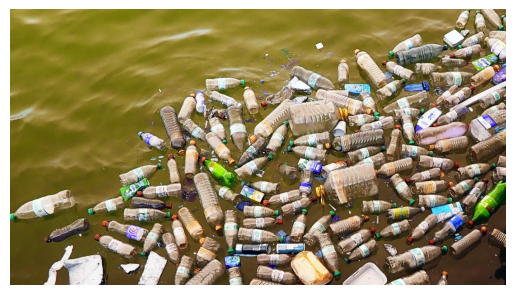

In [11]:
# Load the trained model
model = load_model('plastic_bottle_detector.h5')

# Detect plastic bottles in a new image
image_path = 'plastic-waste-1.jpg'
detect_multiple_plastic_bottles(image_path, model, input_shape)